In [15]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()


In [16]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [17]:
# load the dataset
train_data = torchvision.datasets.MNIST(
    root='.',  # download to local dir
    train=True,
    transform=transforms.ToTensor(),  # transform to Tensor
    download=True
)

In [18]:
# pick one of the images from the data
sample_image = train_data.data[0]
sample_image.shape

torch.Size([28, 28])

It can be observed that an image is 28 px x 28 px. Lets look at the max and min values below

In [19]:
sample_image.max()

tensor(255, dtype=torch.uint8)

So for mnist, torch didnt normalise the pixels. This is contrary to what I used to believe!

In [20]:
# lets look at the targets
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

The target looks like a 1D array of integers representing the classes.

In [21]:
# load the test dataset
test_data = torchvision.datasets.MNIST(
    root='.',  # download to local dir
    train=False,
    transform=transforms.ToTensor(),  # transform to Tensor also preprocess
    download=True
)

In [22]:
# build the model - it outputs logits
model = nn.Sequential(
    nn.Linear(in_features=784, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)  # transfers all the parameters of the model to device

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [24]:
# loss and criterion
criterion = nn.CrossEntropyLoss()  # uses logits to calculate loss
optimizer = optim.Adam(model.parameters())

In [25]:
# creating data loaders/generators with batch size
batch_size = 128
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)  # dont shuffle test data, no need to - extra processing

In [26]:
# look at sample data
tmp_loader = DataLoader(dataset=train_data,
                        batch_size=1,
                        shuffle=False)
for data, target in tmp_loader:
    print(target)
    print(data.max())
    print(target.shape)
    break

tensor([5])
tensor(1.)
torch.Size([1])


It now looks like the max value of a pixel is 1. That is it is normalised. But why we saw that a max vaue of a pixel was 255 earlier ? The reason is, when we call .data attribute on a default dataset, the ToTensor() methos is NOT called. This transformation method is only called through the dataloader and it also does the preprocessing of normalisation.

Another important thing over here is in keras, we have to have targets in label binarized formats for multiclass classification, but here, its not the case.

In [27]:
# train the model
epochs = 10 # we are doing batch gradient descent. total iters is actually 10 x batch_size

# losses to store
epoch_train_losses = np.zeros(epochs)
epoch_test_losses = np.zeros(epochs)

for i in range(epochs):

    avg_train_losses_per_batch = []
    for inputs, targets in train_loader:
        # move inputs to gpu
        inputs, targets = inputs.to(device), targets.to(device)

        # reshape the input
        inputs = inputs.view(-1, 784)  # remeber torch wants inputs in multiD

        # zero the optimizer params
        optimizer.zero_grad()

        #forward pass
        outputs = model(inputs)
        avg_train_loss = criterion(outputs, targets)

        # backward and optimize
        avg_train_loss.backward()
        optimizer.step()
        avg_train_losses_per_batch.append(avg_train_loss.item())

    # calculate the epoch loss
    epoch_train_loss = np.mean(avg_train_losses_per_batch)

    avg_test_losses_per_batch = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 784)
        outputs = model(inputs)
        avg_test_loss = criterion(outputs, targets)
        avg_test_losses_per_batch.append(avg_test_loss.item())
    epoch_test_loss = np.mean(avg_test_losses_per_batch)

    # save the epoch losses
    epoch_train_losses[i] = epoch_train_loss
    epoch_test_losses[i] = epoch_test_loss

    print(f"[INFO] epoch {i+1}/{epochs}, train_loss: {epoch_train_loss: .4f}, test_loss: {epoch_test_loss: .4f}......")


[INFO] epoch 1/10, train_loss:  0.4151, test_loss:  0.2256......
[INFO] epoch 2/10, train_loss:  0.1972, test_loss:  0.1605......
[INFO] epoch 3/10, train_loss:  0.1427, test_loss:  0.1253......
[INFO] epoch 4/10, train_loss:  0.1110, test_loss:  0.1048......
[INFO] epoch 5/10, train_loss:  0.0894, test_loss:  0.0991......
[INFO] epoch 6/10, train_loss:  0.0738, test_loss:  0.0889......
[INFO] epoch 7/10, train_loss:  0.0621, test_loss:  0.0816......
[INFO] epoch 8/10, train_loss:  0.0531, test_loss:  0.0801......
[INFO] epoch 9/10, train_loss:  0.0453, test_loss:  0.0765......
[INFO] epoch 10/10, train_loss:  0.0396, test_loss:  0.0741......


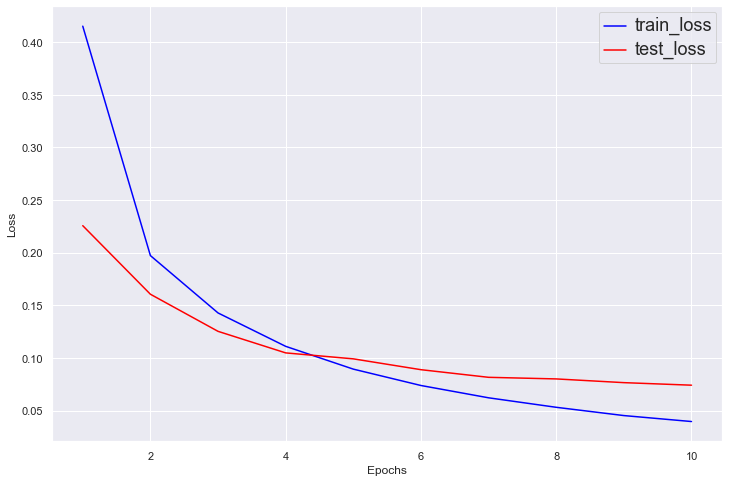

In [28]:
# plot the losses
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(12, 8)) # type: Figure, Axes
sns.lineplot(x=np.arange(epochs) + 1, y=epoch_train_losses, label="train_loss", color="blue", ax=ax)
sns.lineplot(x=np.arange(epochs) + 1, y=epoch_test_losses, label="test_loss", color="red", ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [29]:

# calculating accuracy

model.eval()
with torch.no_grad():

  n_correct = 0
  n_total = 0
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)

    #outputs are logits, max outputs give max probs in softmax
    outputs = model(inputs)

    # max in torch returns max and argmax, we need argmax
    _, indices = torch.max(outputs,dim=1)

    n_correct += (indices == targets).sum().item()
    n_total += targets.shape[0]

  train_acc = n_correct / n_total

  n_correct = 0
  n_total = 0
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)

    #outputs are logits, max outputs give max probs in softmax
    outputs = model(inputs)

    # max in torch returns max and argmax, we need argmax
    _, indices = torch.max(outputs,dim=1)

    n_correct += (indices == targets).sum().item()
    n_total += targets.shape[0]

  test_acc = n_correct / n_total

print(f"train_accuracy: {train_acc: .4f} and test_accuracy: {test_acc: .4f}")


train_accuracy:  0.9928 and test_accuracy:  0.9781


In [30]:
# plot the classification report
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():

  all_predictions = np.array([])
  all_true_targets = np.array([])
  all_xtest = test_data.data.numpy()

  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    resized_inputs = inputs.view(-1, 784)

    #outputs are logits, max outputs give max probs in softmax
    outputs = model(resized_inputs)

    # max in torch returns max and argmax, we need argmax
    _, indices = torch.max(outputs,dim=1)

    all_predictions = np.concatenate((all_predictions, indices.cpu().numpy()))
    all_true_targets = np.concatenate((all_true_targets, targets.cpu().numpy()))


In [31]:
print (classification_report(all_true_targets, all_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       980
         1.0       0.98      0.99      0.99      1135
         2.0       0.98      0.98      0.98      1032
         3.0       0.97      0.99      0.98      1010
         4.0       0.97      0.98      0.98       982
         5.0       0.99      0.97      0.98       892
         6.0       0.98      0.98      0.98       958
         7.0       0.98      0.97      0.98      1028
         8.0       0.97      0.97      0.97       974
         9.0       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [32]:
# conf matrix utility function
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

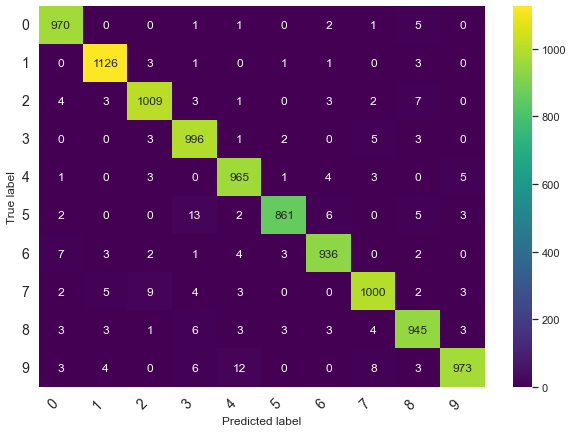

In [33]:
cm = confusion_matrix(all_true_targets,all_predictions)
print_confusion_matrix(cm, class_names=list(range(10)))

true target label: 9.0
predicted label: 3.0


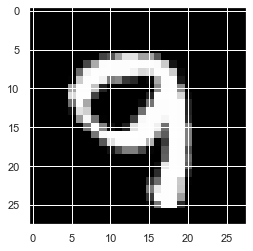

In [34]:
# show some misclassified images
missclassified_id = np.where(all_predictions != all_true_targets)[0] # returns the indices of the array that are non-zero
random_id = np.random.choice(missclassified_id)
print(f"true target label: {all_true_targets[random_id]}")
print(f"predicted label: {all_predictions[random_id]}")

plt.imshow(all_xtest[random_id],cmap="gray")